# MSB1015 Scientific Programming
Nicolas Thiel (i6254307)

In [ ]:
# affinity clustering
# similarity
# step wise cutoff


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Load Data

In [ ]:
df_original = pd.read_csv('data/spotify-features_original.csv', sep=',')
# df = pd.read_csv('data/spotify-features_adjusted.csv', sep=';')
df = df_original.copy()
df.shape

(232725, 18)

## Initial Data Cleaning

### Dropping duplicates

In [ ]:
df = df.drop_duplicates(subset='track_id', keep='first')
df.shape

(176774, 18)

### Missing values

In [ ]:
df.isna().sum()

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Since the data only has very few missing values, I decided to drop them.

In [ ]:
df.dropna(inplace=True)
df.shape

(176773, 18)

### Genre

In [ ]:
print(df['genre'].unique())

['Movie' 'R&B' 'A Capella' 'Alternative' 'Country' 'Dance' 'Electronic'
 'Anime' 'Folk' 'Blues' 'Opera' 'Hip-Hop' "Children's Music"
 'Children’s Music' 'Rap' 'Indie' 'Classical' 'Pop' 'Reggae' 'Reggaeton'
 'Jazz' 'Rock' 'Ska' 'Comedy' 'Soul' 'Soundtrack' 'World']


I exclude the genres Comedy, as it does not contain songs but rather comedy bits or stand-up, as well as Opera.

In [ ]:
# Remove Opera and Comedy genres
df = df[~df['genre'].isin(['Opera', 'Comedy'])]
df.shape

(158819, 18)

Furthermore, there exist two labels for children music, so I combined them.

In [ ]:
# Merge both children's genres into a single label
df['genre'] = df['genre'].replace({'Children’s Music': 'Children', "Children's Music": 'Children'})
df['genre'].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Hip-Hop', 'Children',
       'Rap', 'Indie', 'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz',
       'Rock', 'Ska', 'Soul', 'Soundtrack', 'World'], dtype=object)

### Time Signature

In [ ]:
df['time_signature'].value_counts()

time_signature
4/4    139558
3/4     14915
5/4      2874
1/4      1470
0/4         2
Name: count, dtype: int64

In [ ]:
df = df[~df['time_signature'].isin(['0/4', '1/4'])]
df.shape

(157347, 18)

## Exploratory Data Analysis

In [ ]:
continuous_features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
categorical_features = ['key', 'mode', 'time_signature']

### How much is a genre explained by each feature?

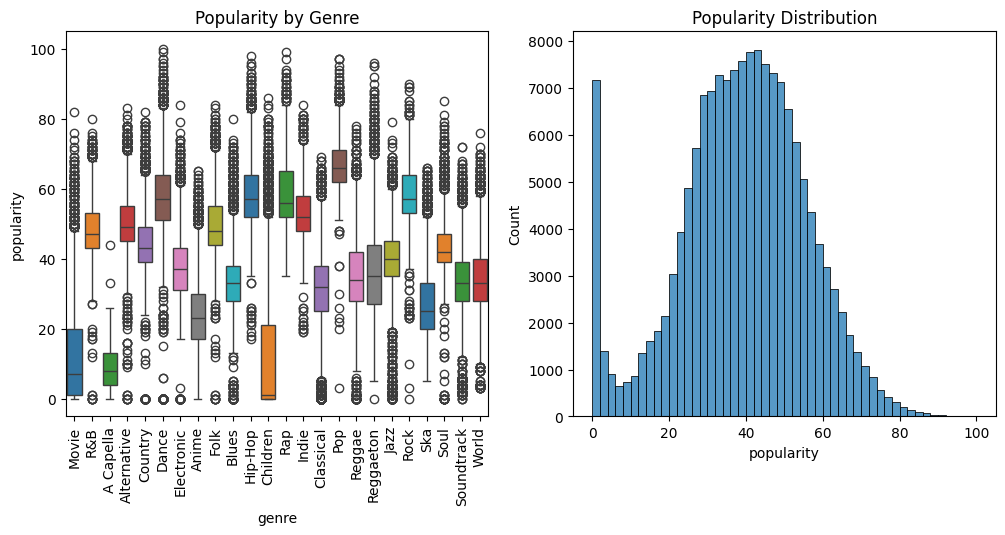

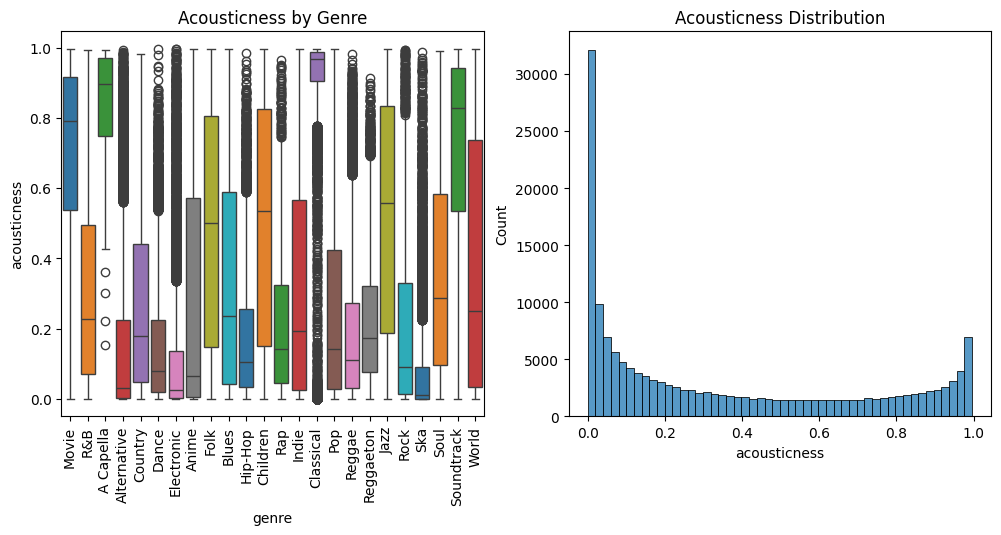

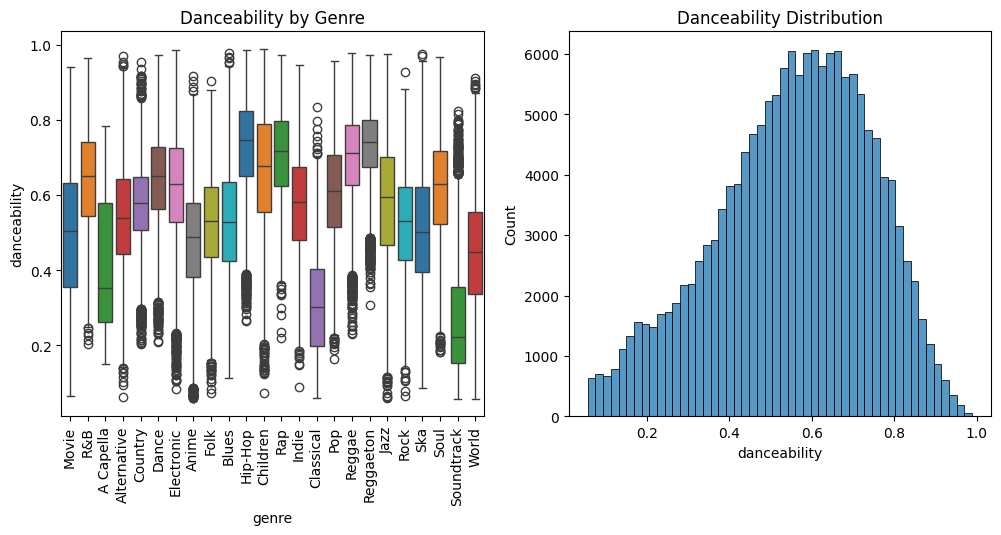

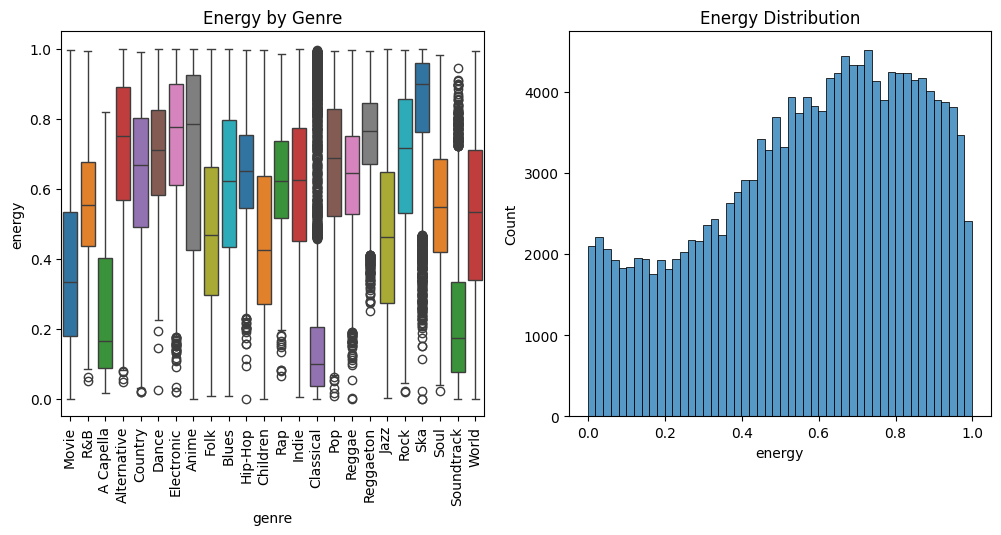

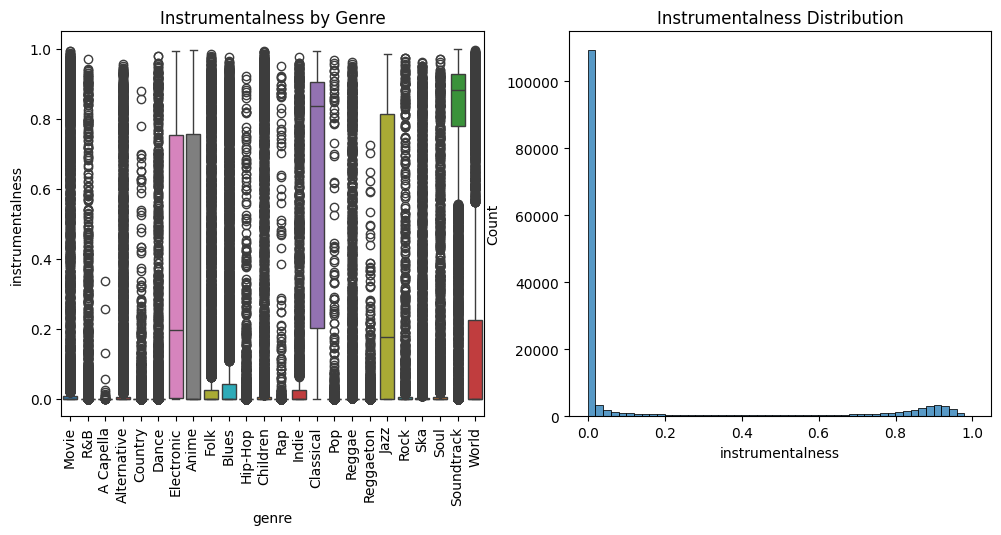

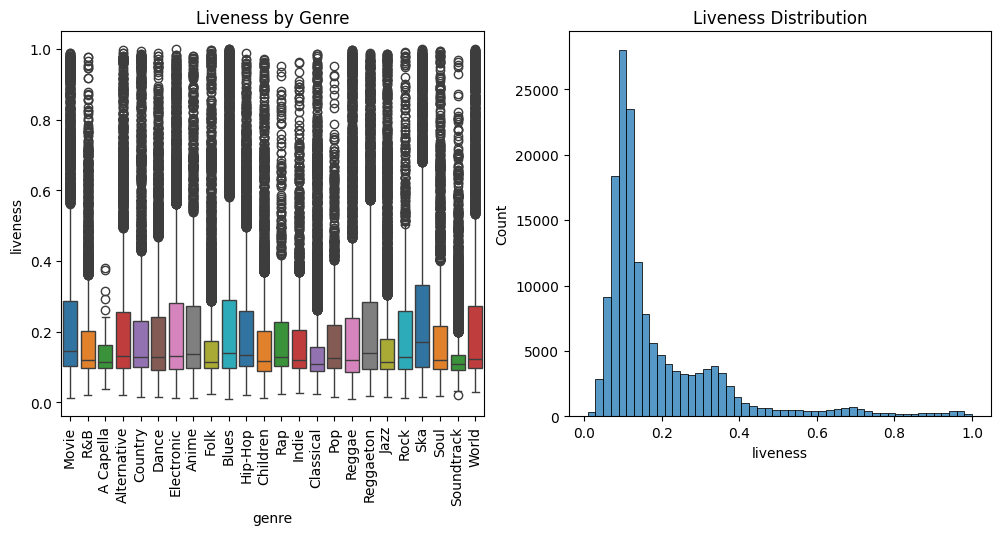

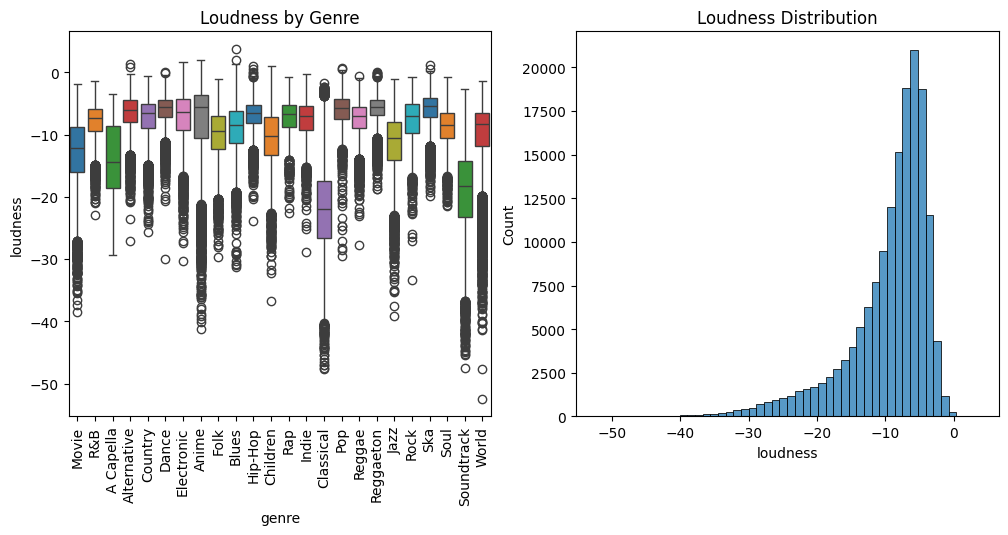

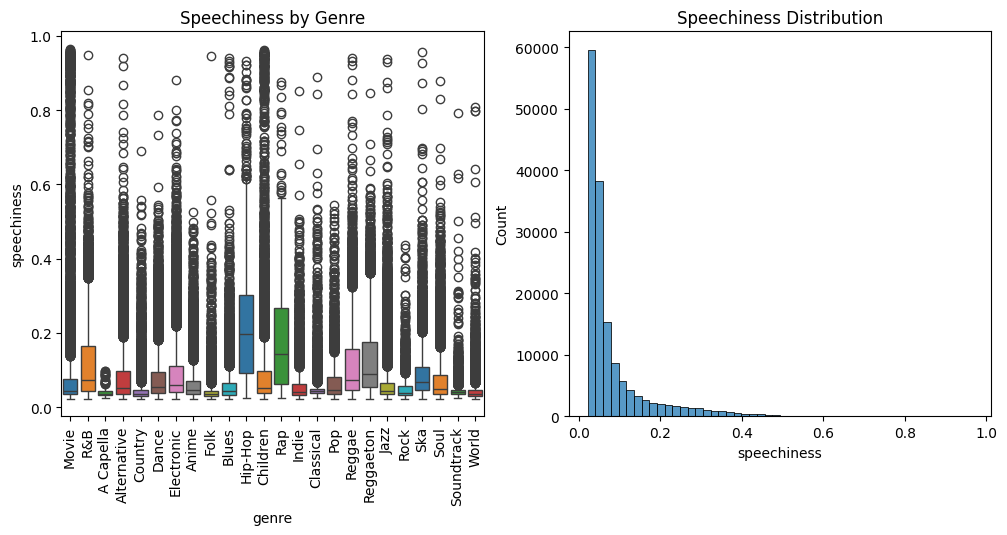

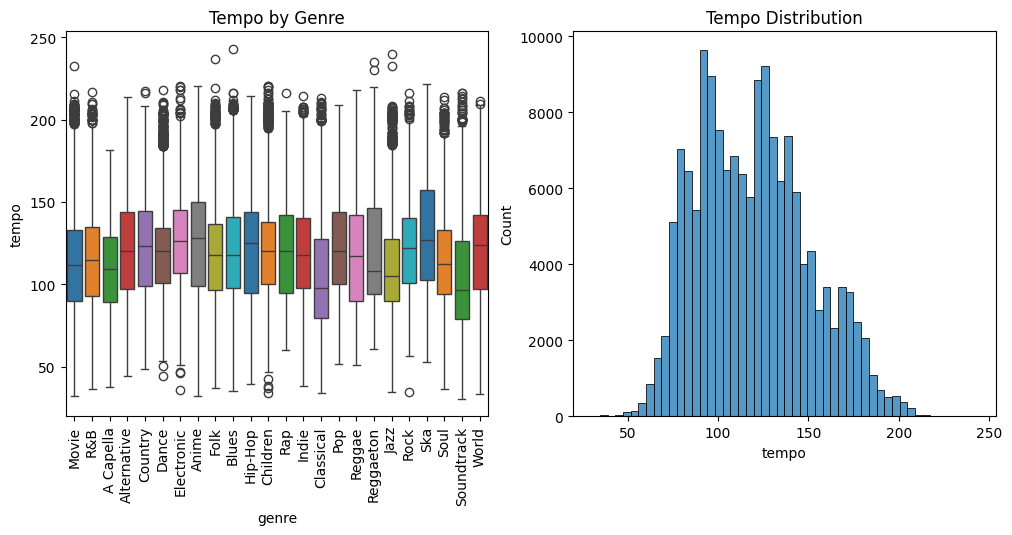

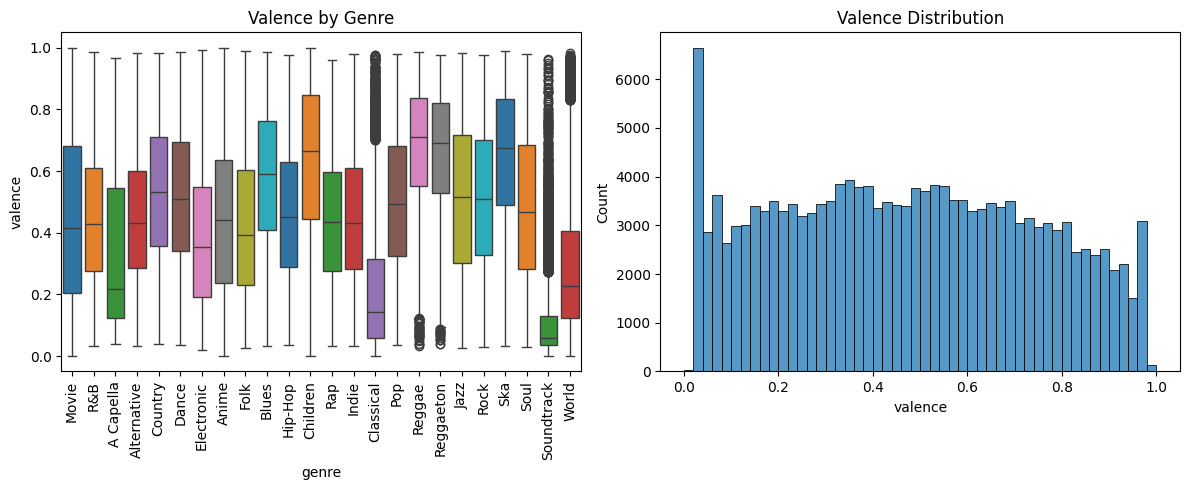

In [ ]:
for feature in continuous_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='genre', y=feature, hue='genre', palette='tab10')
    plt.xticks(rotation=90)
    plt.title(f'{feature.capitalize()} by Genre')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=feature, bins=50)
    plt.title(f'{feature.capitalize()} Distribution')

plt.tight_layout()
plt.show()

## Anomaly Detection and Removal

In [ ]:
from sklearn.ensemble import IsolationForest

df_clean = df.copy()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=1)
outlier_pred = iso_forest.fit_predict(df_clean[continuous_features])

# Add outlier flag to dataframe (-1 is outlier, 1 is inlier)
df_clean['outlier'] = (outlier_pred == -1)
print(df_clean['outlier'].value_counts())

outlier
False    155773
True       1574
Name: count, dtype: int64


In [ ]:
df_clean = df_clean[~df_clean['outlier']]
df_clean.shape

(155773, 19)

### Revisit plots

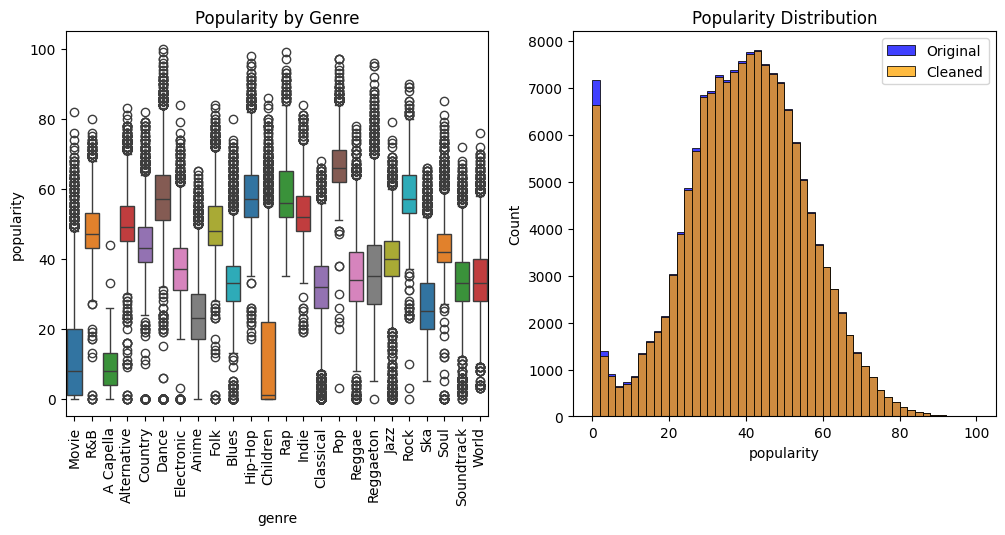

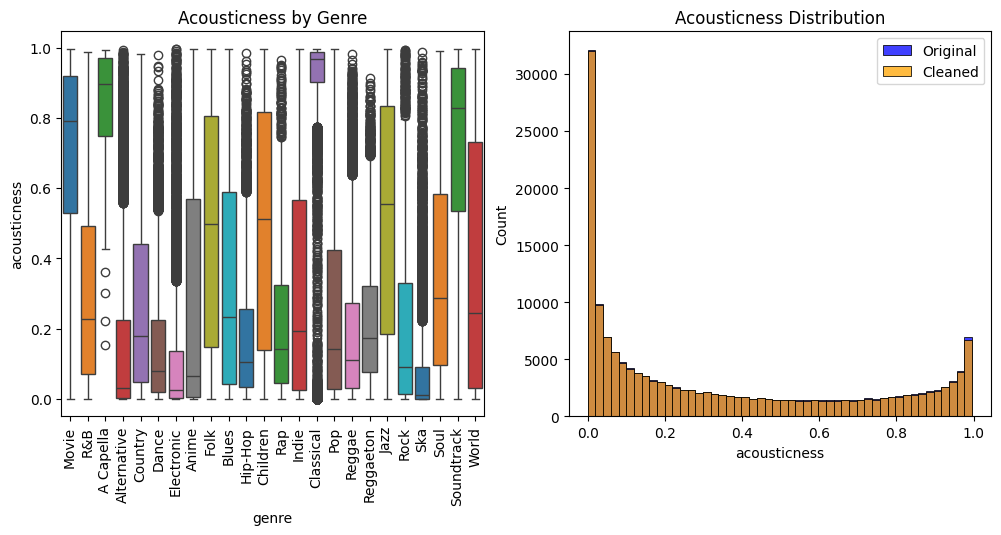

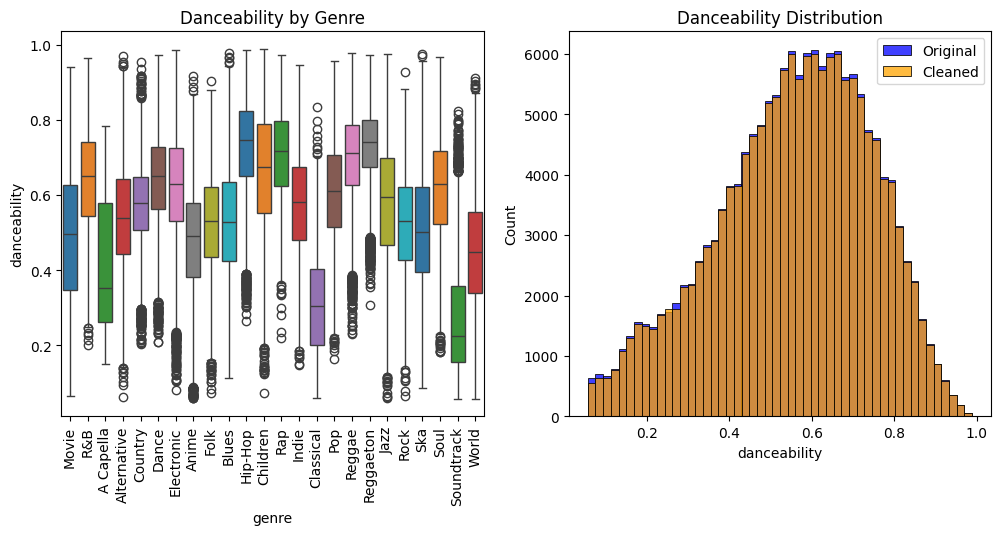

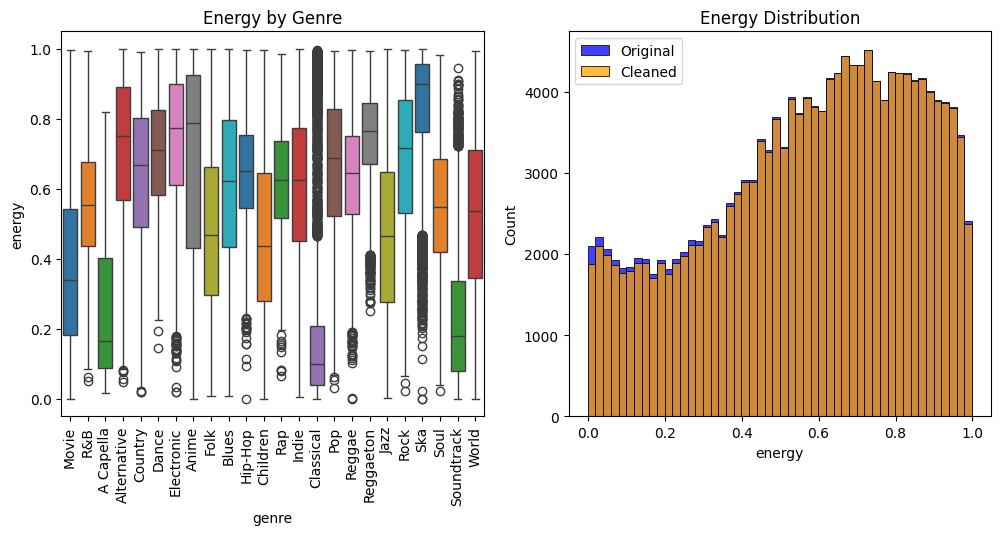

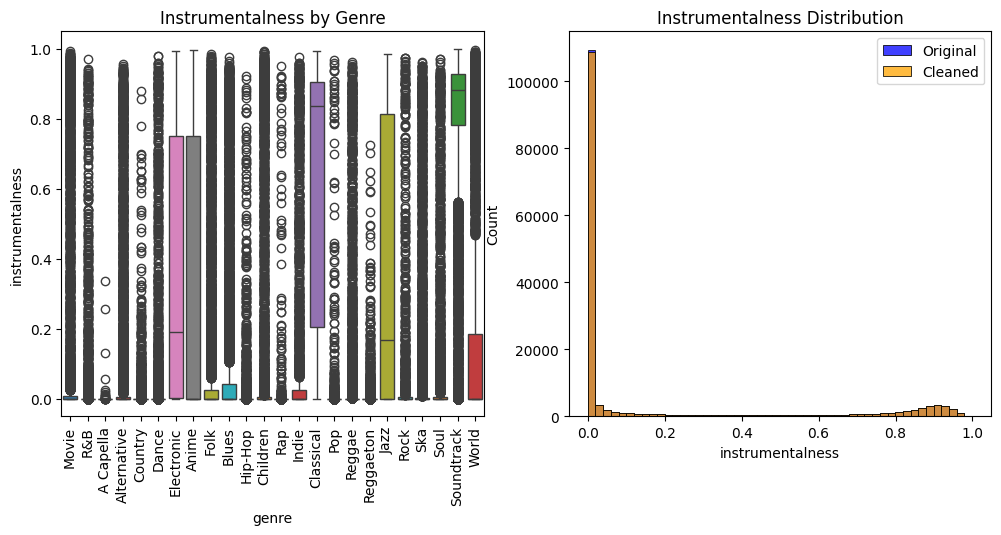

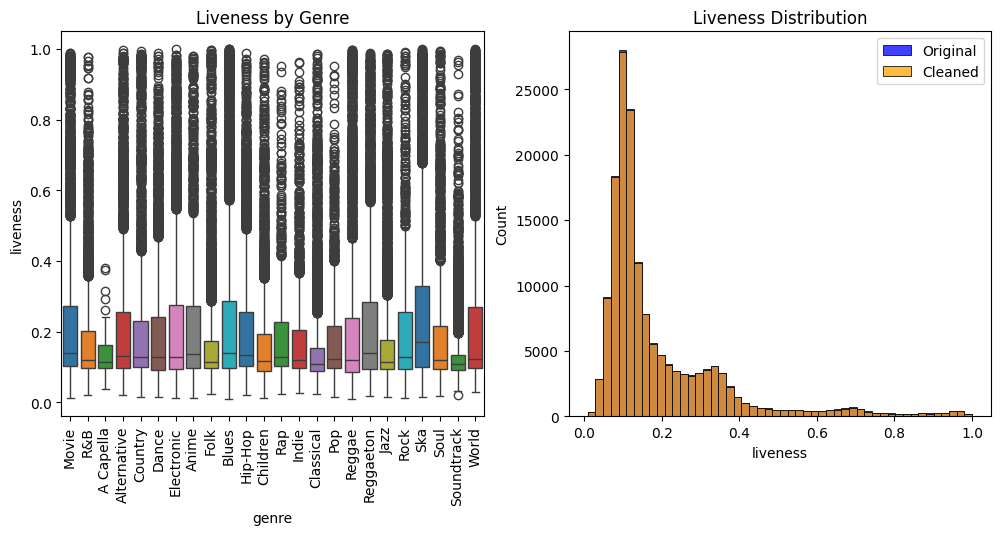

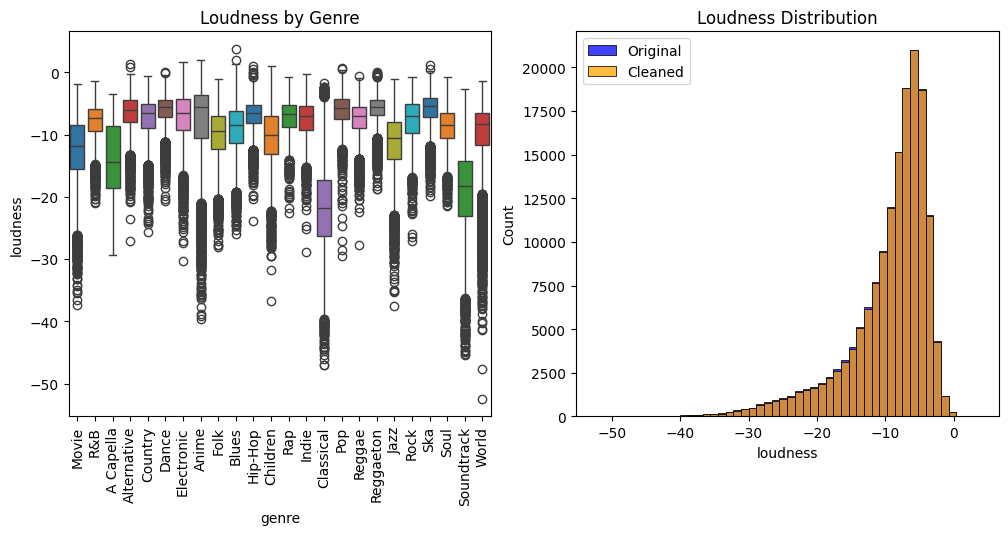

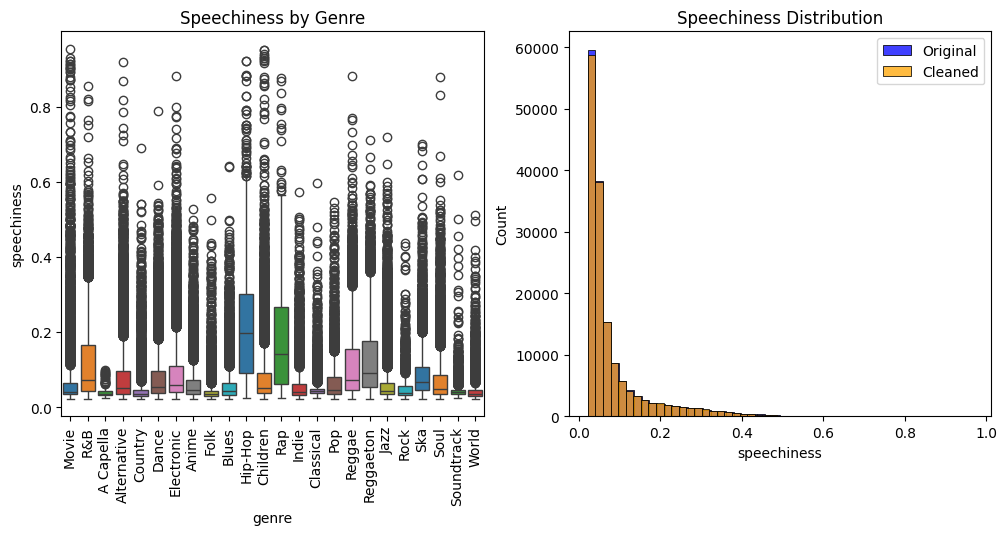

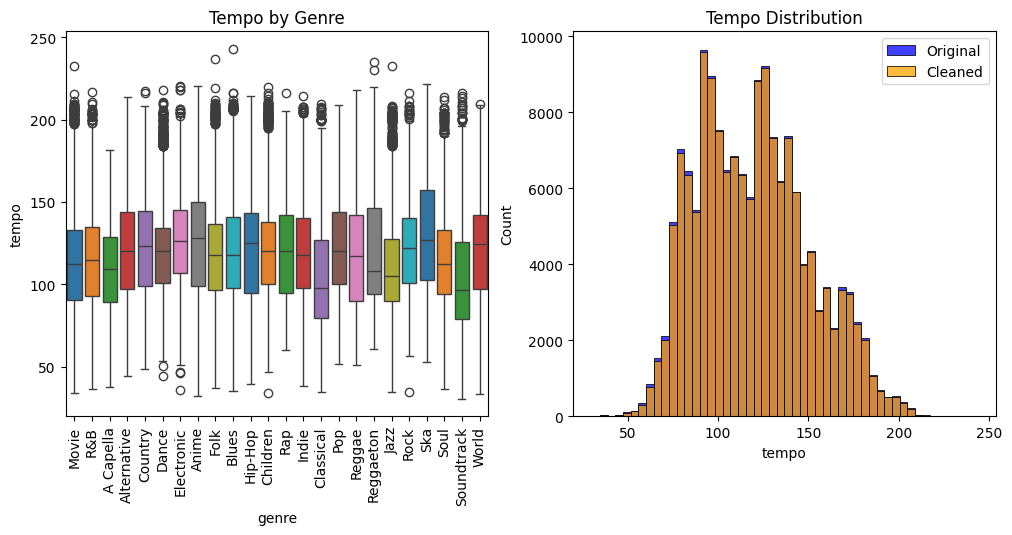

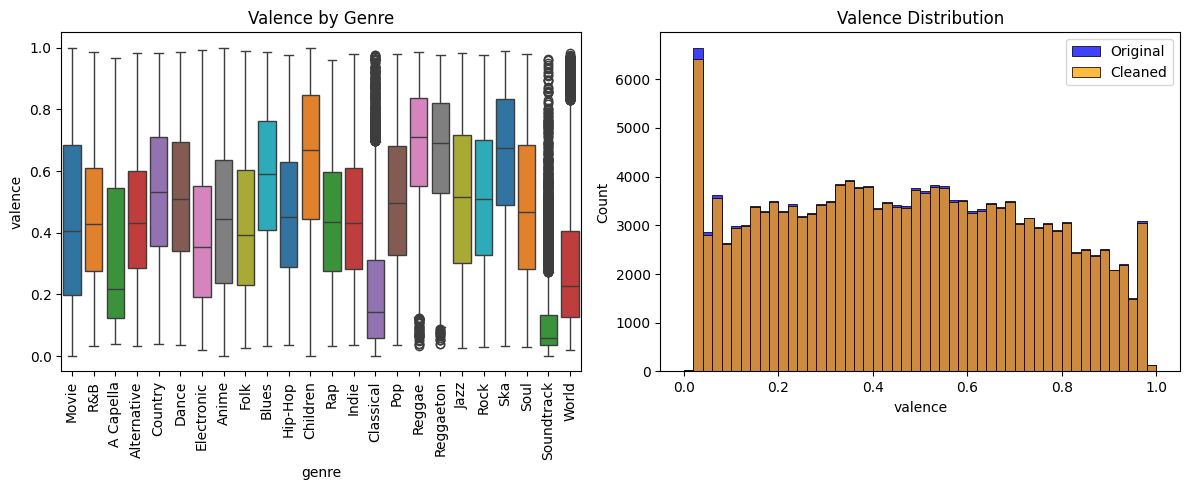

In [ ]:
for feature in continuous_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_clean, x='genre', y=feature, hue='genre', palette='tab10')
    plt.xticks(rotation=90)
    plt.title(f'{feature.capitalize()} by Genre')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=feature, bins=50, color='blue', label='Original')
    sns.histplot(data=df_clean, x=feature, bins=50, color='orange', label='Cleaned')
    plt.title(f'{feature.capitalize()} Distribution')
    plt.legend()

plt.tight_layout()
plt.show()

## Clustering

In [ ]:
X = df_clean.drop(columns=['track_id', 'track_name', 'artist_name', 'genre'])

### K-means on PCA dimensionality-reduced data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


categorical_features = ['key', 'mode', 'time_signature']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pca = PCA(n_components=0.95, random_state=1)  # keep 95% variance

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("pca", pca),
])

Find ideal number of clusters

In [ ]:
from sklearn.metrics import silhouette_score

X_transformed = pipeline.fit_transform(X)

# Elbow method
inertias = []
silhouette_scores = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=1, n_init=10)
    km.fit(X_transformed)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_transformed, km.labels_, sample_size=1000))

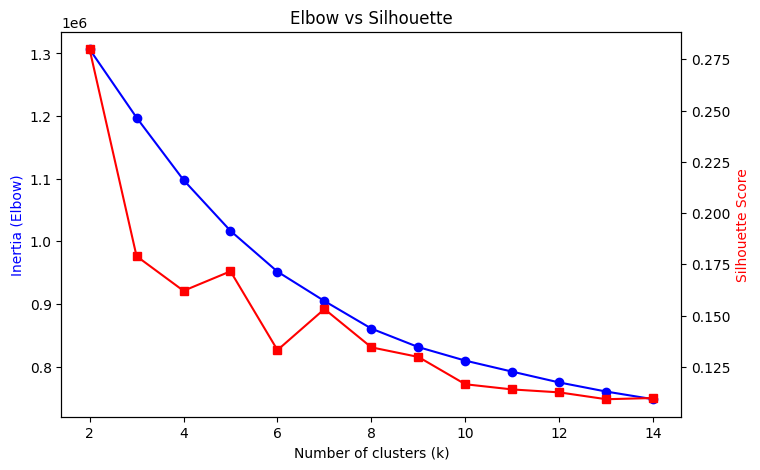

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(range(2, 15), inertias, marker="o", color="blue")
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Inertia (Elbow)", color="blue")

ax2 = ax1.twinx()
ax2.plot(range(2, 15), silhouette_scores, marker="s", color="red")
ax2.set_ylabel("Silhouette Score", color="red")

plt.title("Elbow vs Silhouette")
plt.show()

Apply clustering

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
pipeline.steps.append(("cluster", kmeans))

In [ ]:
pipeline.fit(X)
df_clean["cluster"] = pipeline["cluster"].labels_
print(df_clean["cluster"].value_counts())

cluster
2    74298
1    34769
3    20417
0    15928
4    10361
Name: count, dtype: int64


Visualize in PCA space

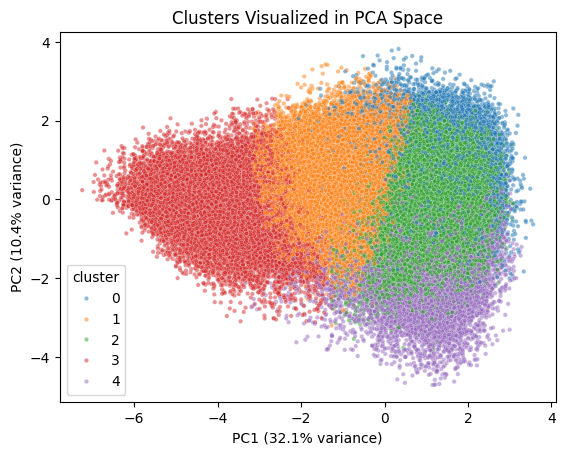

In [ ]:
plt.figure()
sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=df_clean["cluster"], palette="tab10", alpha=0.5, s=10, legend="full")
explained_var = pipeline[:-1].named_steps["pca"].explained_variance_ratio_
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.title("Clusters Visualized in PCA Space")
plt.show()